577
1280
(1, 1, 3)


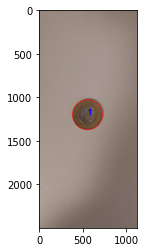

In [9]:
%matplotlib inline


import imutils
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("real/coins 7.jpg", cv2.IMREAD_COLOR)

height, width, depth = img.shape
print(width)
print(height)
d = max(width, height)

if d == width:
    img = imutils.resize(img, width = 2500)
else:
    img = imutils.resize(img, height = 2500)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(gray,cv2.MORPH_OPEN,kernel, iterations = 2)
blur = cv2.medianBlur(opening, 7)
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.3, (int) (d / 10), param1 = 100, param2 = 75, maxRadius = (int) (d / 4))
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i, c in enumerate(circles[0, :]):
        cv2.circle(img, (c[0], c[1]), c[2], (255, 0, 0), 5)
        cv2.putText(img, str(i + 1), (c[0], c[1]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12, cv2.LINE_AA)
plt.imshow(img, cmap = 'gray')
print(circles.shape)

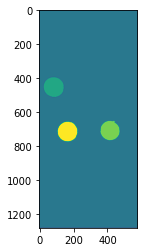

In [3]:
img = cv2.imread('real/coins 6.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)

opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

sure_bg = cv2.dilate(opening,kernel,iterations=3)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1

markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.imshow(markers)